<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необходимо построить модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Для того чтобы спрогнозировать количество заказов, мы выполним следующие шаги:

1. Загрузим данные и выполним их ресемплирование по одному часу.
2. Проанализируемые полученные данные.
3. Обучим разные модели. 
4. Проверим данные на тестовой выборке.


## Подготовка

In [41]:
# импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from statsmodels.tsa.seasonal import seasonal_decompose

In [42]:
# загрузка данных и обзор таблиц
data = pd.read_csv('/datasets/taxi.csv', parse_dates = [0])
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [43]:
data.describe(include='all')

/tmp/ipykernel_122/1336221646.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  data.describe(include='all')


,datetime,num_orders
count,26496,26496.000000
unique,26496,NaN
top,2018-03-09 22:10:00,NaN
freq,1,NaN
first,2018-03-01 00:00:00,NaN
last,2018-08-31 23:50:00,NaN
mean,NaN,14.070463
std,NaN,9.211330
min,NaN,0.000000
25%,NaN,8.000000


Представлены данные за период с 1 марта 2018 по 31 августа 2018 года. По количеству заказов мы видим, что присутствуют пики, т.к. среднее значение 14, медианное значение 19, а максимальное - 119. Это осложнит предсказания модели - пики предсказывать всегда сложно, если только они не носят повторяющийся характер. <br>
Отсортируем данные и посмотрим на наличие дубликатов.

In [44]:
data = data.sort_values(by = 'datetime')
data

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
...,...,...
26491,2018-08-31 23:10:00,32
26492,2018-08-31 23:20:00,24
26493,2018-08-31 23:30:00,27
26494,2018-08-31 23:40:00,39


In [45]:
data.duplicated().sum()

0

Данные отсортированы. Дубликатов нет, ничего удалять не нужно.

In [46]:
data.index = data['datetime']
data = data.drop('datetime', axis =1)

Мы провели первичный анализ и подготовку данных, теперь можем приступить к анализу данных.

## Анализ

В процессе анализа исходных данных мы предпримем следующие шаги: <br>
1. ресемплируем данные
2. поищем сезонные закономерности

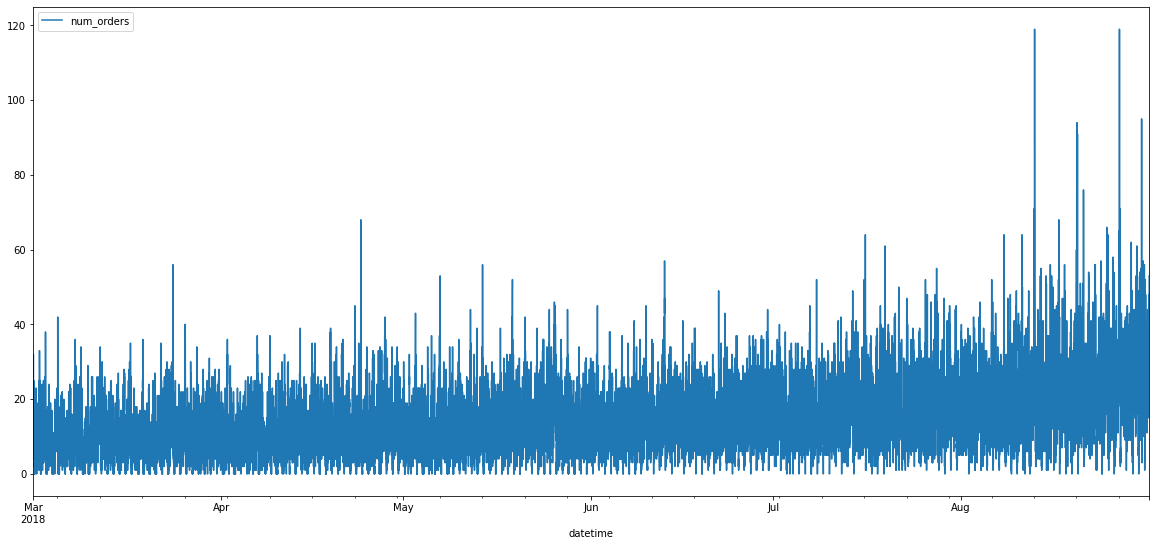

In [47]:
data.plot(figsize =(20,9));

Как и ожидалось по описательной статистике, данные имеют локальные пики, повторяющиеся с неравномерной регулярностью. <br>
Проведем ресемплирование данных по 1 часу.

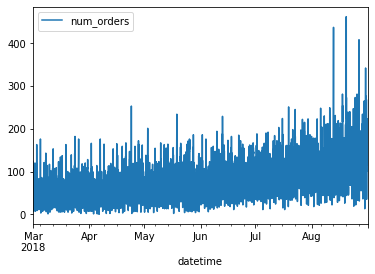

In [48]:
data = data.resample('1H').sum()
data.plot();

Посмотрим, есть ли сезонность в данных, и каковы ее показатели.

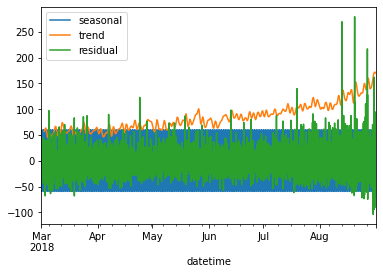

In [49]:
data['seasonal'] = seasonal_decompose(data['num_orders']).seasonal
data['trend'] = seasonal_decompose(data['num_orders']).trend.rolling(24).mean()
data['residual'] = seasonal_decompose(data['num_orders']).resid
data[['seasonal', 'trend', 'residual']].plot();

Сезонность (seasonal) плохо визуализируется на графике за весь период. Выберем небольшой промежуток в три дня и посмотрим на этот период.

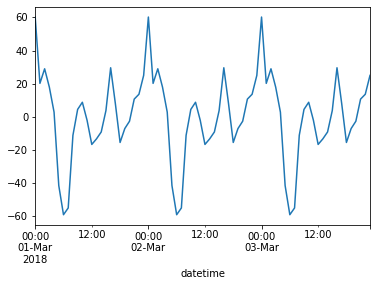

In [50]:
data.loc['2018-03-01':'2018-03-03', 'seasonal'].plot();

Мы видим на графиках, что есть небольшой растущий тренд от начала периода (март 2018) к концу периода (август 2018) и видим на графике сезонность, которая повторяется в течение дня. <br>
Residual показывает пики, которые, как мы и отмечали раньше, не имеют регулярного характера.

Подготовим дополнительные признаки, которые можем извлечь из даты - день, месяц, час. А также уберем пока признаки, связанные с сезонностью.

In [51]:
data = data.drop(['seasonal', 'trend', 'residual'], axis =1)
data['month']= data.index.month
data['dayofweek'] = data.index.dayofweek
data['hour'] = data.index.hour
data.head()

,num_orders,month,dayofweek,hour
datetime,,,,
2018-03-01 00:00:00,124,3,3,0
2018-03-01 01:00:00,85,3,3,1
2018-03-01 02:00:00,71,3,3,2
2018-03-01 03:00:00,66,3,3,3
2018-03-01 04:00:00,43,3,3,4


Для прогнозирования целевого признака нам скорее всего будет недостаточно тех календарных признаков, которые есть в нашем распоряжении. Поэтому мы можем создать дополнительные признаки - скользящее среднее, принимающее последние n периодов, и отсроченные значения, для того чтобы установить, как меняется со временем целевой признак - уменьшается или растет. <br><br>
Мы создадим функцию, которая создает эти признаки, параметрами которой будут количество периодов скользащего среднего и количество отслеживаемых периодов для подсчета тренда (лаг). <br>В эту же функцию мы интегрируем разбитие датасета на признаки и таргет, а также разбитие датасета на трейновый, валидационный и тестовый. Последний составляет 10% от всего датасета. К нему мы вернемся в последней главе, а пока будем обучать модель на трейновом датасете, а считать метрики на валидационном.<br>
Функция будет возвращать несколько датасетов (признаки и таргет отдельно):
* train - трейновый датасет 
* trainval - вместе валидационный и трейновый датасеты (для обучения модели на стадии тестов)
* val - валидационный датасет
* test - тестовый датасет

In [52]:
def new_features_and_split(data, max_lag, rolling_size):
    new_data = data
    new_data['rolling'] = new_data['num_orders'].shift().rolling(rolling_size).mean()
    for lag in range(1, max_lag + 1):
        new_data['lag_{}'.format(lag)] = new_data['num_orders'].shift(lag)
    new_data = new_data.dropna()
    features = new_data.drop('num_orders', axis =1)
    target = new_data['num_orders']
    features_trainval, features_test, target_trainval, target_test = train_test_split(features, 
                                                                                    target, 
                                                                                    shuffle = False, 
                                                                                    test_size = 0.1)
    features_train, features_val, target_train, target_val = train_test_split(features_trainval, 
                                                                               target_trainval,
                                                                               shuffle = False,
                                                                               test_size = 0.25)
    return features_trainval, features_test, target_trainval, target_test,features_train, features_val, target_train, target_val

Теперь, когда функция создана, все готово к обучению.

## Обучение

В этой главе мы обучим несколько моделей (LinearRegression, KNN, CatBoost) и проведем валидационные тесты. Для начала создадим константную модель, которая за прогноз принимает медианное значение целевого признака, и все модели будем сравнивать с ней.

In [53]:
# dummy model "median"
features = data.drop('num_orders', axis =1)
target = data['num_orders']
features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                            target, 
                                                                            shuffle = False, 
                                                                            test_size = 0.1)

pred_median = np.ones(target_test.shape)*target_train.median()
rmse_dummy = mean_squared_error(target_test, pred_median)**0.5
print(f'RMSE на константной модели: {round(rmse_dummy,3)}')

RMSE на константной модели: 87.153


RMSE на константной модели довольно высокий, то есть плохой. Посмотрим, смогут ли модели улучшить результат. <br>
Для каждой модели мы попробуем различные значения лага и промежутка скольжения и выберем наилучшие. Для того, чтобы сравнивать между собой эти параметры и визуализировать результаты расчета, создадим таблицу, где будут храниться все значения метрики при всех параметрах модели. <br>
Так же в целях визуализации создадим графики, на которых будут сравниваться предсказания модели и правильные ответы валидационного датасета. Таким образом мы сможем увидеть, насколько наша модель хорошо предсказывает значения.

In [14]:
# Linear regression
best_rmse = rmse_dummy 
best_rolling = 0
best_lag = 0
table_LR = pd.DataFrame(columns = range(2, 25,4), index = range(1,25,4))
for max_lag in range(1,25, 4):
    for rolling in range(2, 25,4):
        features_trainval, features_test, target_trainval, target_test, features_train, features_val, target_train, target_val = new_features_and_split(data, max_lag, rolling)
        
        model_LR = LinearRegression()
        model_LR.fit(features_train, target_train)
        rmse = mean_squared_error(target_val, model_LR.predict(features_val))**0.5
        table_LR.loc[max_lag, rolling] = round(rmse, 3)
        if rmse < best_rmse:
            best_rmse = rmse
            best_lag = max_lag
            best_rolling = rolling
table_LR


,2,6,10,14,18,22
1,37.771,37.744,37.813,37.844,37.976,38.032
5,37.657,37.676,37.686,37.685,37.878,37.926
9,37.562,37.562,37.597,37.528,37.731,37.777
13,37.28,37.28,37.28,37.15,37.352,37.483
17,37.1,37.1,37.1,37.1,36.473,37.183
21,36.353,36.361,36.361,36.361,36.361,35.206


In [15]:
print(f'Лучший промежуток скользящего среднего: {best_rolling}, лучший лаг: {best_lag}')

Лучший промежуток скользящего среднего: 22, лучший лаг: 21


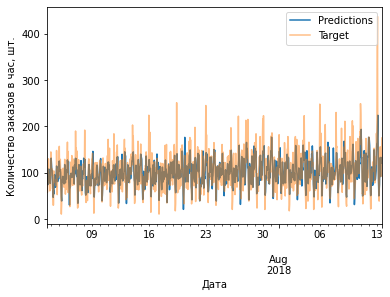

In [16]:
features_trainval, features_test, target_trainval, target_test, features_train, features_val, target_train, target_val = new_features_and_split(data, 23, 24)

model_LR.fit(features_train, target_train)
pd.DataFrame(model_LR.predict(features_val), index = target_val.index).plot();
target_val.plot(alpha = 0.5);
plt.ylabel('Количество заказов в час, шт.')
plt.xlabel('Дата')
plt.legend(['Predictions', 'Target']);

Линейная регрессия с наилучшими гиперпараметрами хорошо прогнозирует "профиль" кривой, но судя по графику, амплитуда раброса значений недостаточна, плохо покрывает и максимальные и минимальные значения (оранжевая кривая).

In [17]:
# CatBoost
best_rmse = rmse_dummy 
best_rolling = 0
best_lag = 0
table_CB = pd.DataFrame(columns = range(2, 25,4), index = range(1,25,4))
for max_lag in range(1,25, 4):
    for rolling in range(2, 25,4):
        features_trainval, features_test, target_trainval, target_test, features_train, features_val, target_train, target_val = new_features_and_split(data, max_lag, rolling)
    
        model_CB = CatBoostRegressor(verbose = False)
        model_CB.fit(features_train, target_train)
        rmse = mean_squared_error(target_val, model_CB.predict(features_val))**0.5
        table_CB.loc[max_lag, rolling] = round(rmse, 3)
        if rmse < best_rmse:
            best_rmse = rmse
            best_lag = max_lag
            best_rolling = rolling
table_CB

,2,6,10,14,18,22
1,29.889,29.963,30.249,30.206,30.252,31.2
5,29.889,29.963,30.249,30.206,30.252,31.2
9,29.889,29.963,30.249,30.206,30.252,31.2
13,29.889,29.963,30.249,30.206,30.252,31.2
17,29.889,29.963,30.249,30.206,30.252,31.2
21,29.889,29.963,30.249,30.206,30.252,31.2


In [18]:
print(f'Лучший промежуток скользящего среднего: {best_rolling}, лучший лаг: {best_lag}')

Лучший промежуток скользящего среднего: 2, лучший лаг: 1


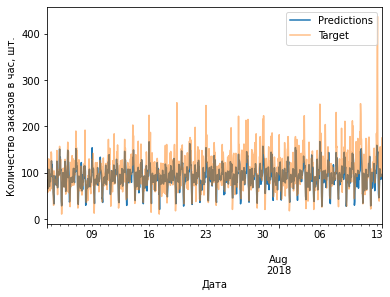

In [19]:
features_trainval, features_test, target_trainval, target_test, features_train, features_val, target_train, target_val= new_features_and_split(data, 1, 2)
                                                                              
pd.DataFrame(model_CB.predict(features_val), index = target_val.index).plot();
target_val.plot(alpha = 0.5)
plt.ylabel('Количество заказов в час, шт.')
plt.xlabel('Дата')
plt.legend(['Predictions', 'Target']);

CatBoost оказалась нечувствительна к изменению лага, а количество периодов скольжения для этой модели оказался меньшим, чем у линейной регрессии - оптимальным является минимальное значение. Судя по графику, модель тоже нечувствительна к пикам, а вот минимальные значения покрывает хорошо. То есть CatBoost строит более пессимистичный прогноз, чем в реальности, это следует учитывать.

In [54]:
# KNN
best_rmse = rmse_dummy 
best_rolling = 0
best_lag = 0
table_KN = pd.DataFrame(columns = range(2, 25,3), index = range(1,25,3))
for lag in range(1,25,3):
    for rolling in range(2, 25,3):
        features_trainval, features_test, target_trainval, target_test, features_train, features_val, target_train, target_val = new_features_and_split(data, lag, rolling)
    
        model_KN = KNeighborsRegressor()
        model_KN.fit(features_train, target_train)
        rmse = mean_squared_error(target_val, model_KN.predict(features_val))**0.5
        table_KN.loc[lag, rolling] = round(rmse, 3)
        if rmse < best_rmse:
            best_rmse = rmse
            best_lag = lag
            best_rolling = rolling
table_KN

,2,5,8,11,14,17,20,23
1,41.458,42.712,41.709,41.144,41.043,41.122,42.098,42.61
4,41.66,41.178,40.502,41.188,41.37,42.297,42.633,41.597
7,40.084,40.331,40.147,39.99,39.826,39.735,39.989,39.252
10,38.071,38.824,38.867,38.642,38.741,39.102,39.103,38.846
13,36.881,37.318,37.258,37.147,37.128,37.137,37.222,36.863
16,36.351,36.305,36.325,36.275,36.271,36.381,36.305,36.073
19,34.514,34.82,34.846,34.928,34.902,34.944,34.952,34.943
22,33.91,34.053,34.174,34.15,34.083,34.13,34.082,34.123


In [55]:
print(f'Лучший промежуток скользящего среднего: {best_rolling}, лучший лаг: {best_lag}')

Лучший промежуток скользящего среднего: 2, лучший лаг: 22


Лучшая RMSE 33.97445874121898 достигается при N-neighbors 6 и Leaf_size 10


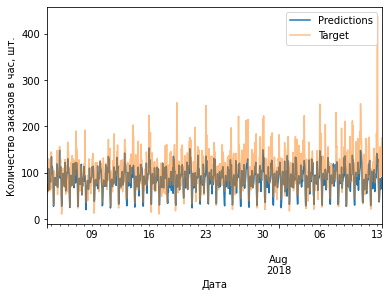

In [60]:
features_trainval, features_test, target_trainval, target_test, features_train, features_val, target_train, target_val= new_features_and_split(data, 2, 22)
                                                                              
# подберем гиперпараметры для модели KNN
best_leaf =0
best_n = 0
best_rmse = rmse_dummy
for n_neighb in range(2, 10):
    for leaf in range(10, 91, 10):
        model_KN = KNeighborsRegressor(n_neighbors = n_neighb, leaf_size = leaf)
        model_KN.fit(features_train, target_train)
        rmse = mean_squared_error(target_val, model_KN.predict(features_val))**0.5
        if rmse < best_rmse:
            best_leaf = leaf
            best_n = n_neighb
            best_rmse = rmse

print(f'Лучшая RMSE {round(best_rmse, 3)} достигается при N-neighbors {best_n} и Leaf_size {best_leaf}')
pd.DataFrame(model_KN.predict(features_val), index = target_val.index).plot();
target_val.plot(alpha = 0.5)
plt.ylabel('Количество заказов в час, шт.')
plt.xlabel('Дата')
plt.legend(['Predictions', 'Target']);

KNN тоже нечувствительна к лагу и периоду скольжения, значения метрики практически не различаются между собой. В целом характер ее предсказаний, судя по графику, похож на CatBoost (в сторону занижения), и даже более пессимистичный; лучшая метрика выше, чем на CatBoost.

**Вывод** <br>
Мы сравнили несколько моделей - линейную регрессию, CatBoost и KNN. Наилучшие результаты по метрике RMSE и по графикам покрытия правильных ответов нам дала модель CatBoost, поэтому мы выберем ее и на ней проведем тестирование.

## Тестирование

Мы обучим модель на данных, соответствующих совокупности трейновой и валидационной выборки, и затем получим предсказания для тестового датасета, который составляет 10% от общего датасета.

In [23]:
features_trainval, features_test, target_trainval, target_test, features_train, features_val, target_train, target_val = new_features_and_split(data, best_lag, best_rolling)
model = CatBoostRegressor(verbose = False)
model.fit(features_trainval, target_trainval)
rmse = mean_squared_error(target_test, model.predict(features_test))**0.5
print('RMSE на тестовой выборке:', round(rmse, 3))

RMSE на тестовой выборке: 40.359


Посмотрим, насколько кривая предсказаний совпадает с кривой правильных ответов.

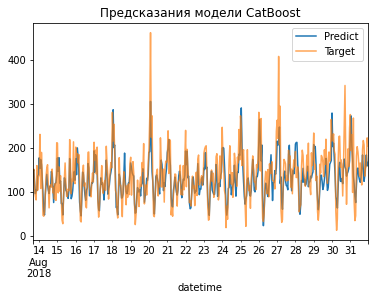

In [24]:
pd.DataFrame(model.predict(features_test), index = target_test.index).plot();
target_test.plot(alpha = 0.7)
plt.title('Предсказания модели CatBoost')
plt.legend(['Predict', 'Target']);

В целом, совпадение достаточно хорошее, но мы видим, что модель не очень хорошо предсказывает пики (максимумы и минимумы), а в случае с прогнозом заказов такси это может быть достаточно критично. <br>
Попробуем улучшить результаты модели при помощи сезонности.

In [25]:
data['seasonal'] = seasonal_decompose(data['num_orders']).seasonal

Поскольку, как мы выяснили во второй главе, сезонность имеет четкую закономерность и повторяемость, мы можем попробовать предсказать значение сезонности для тестового наборка признаков, основываясь на календарно-временных параметрах признаков. <br>
Посмотрим, что получается, если выполнить моделирование.

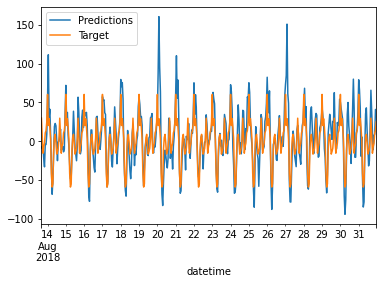

In [26]:
data = data.dropna()
features = data.drop('seasonal', axis =1)
target = data['seasonal']
features_train_season, features_test_season, target_train_season, target_test_season = train_test_split(features, target, shuffle = False, test_size = 0.1)
model_season = LinearRegression()
model_season.fit(features_train_season, target_train_season)
pd.Series(model_season.predict(features_test_season), index = target_test_season.index).plot()
target_test_season.plot()
plt.legend(['Predictions', 'Target']);

Модель достаточно хорошо справляется с прогнозированием сезонности для тестовой выборки. Значит, мы можем интегрировать этот прием в нашу функцию добавления признаков - добавим признак сезонности в датасет для всех наборов данных (но в тестовом наборе спрогнозируем его самостоятельно на основании созданной модели).

In [27]:
def new_features_and_split(data, max_lag, rolling_size):
    new_data = data
    new_data['rolling'] = new_data['num_orders'].shift().rolling(rolling_size).mean()
    for lag in range(1, max_lag + 1):
        new_data['lag_{}'.format(lag)] = new_data['num_orders'].shift(lag)
    new_data = new_data.dropna()
    features = new_data.drop('num_orders', axis =1)
    features['seasonal']=  seasonal_decompose(data['num_orders']).seasonal
    target = new_data['num_orders']
    features_trainval, features_test, target_trainval, target_test = train_test_split(features, 
                                                                                    target, 
                                                                                    shuffle = False, 
                                                                                    test_size = 0.1)
    features_train, features_val, target_train, target_val = train_test_split(features_trainval, 
                                                                               target_trainval,
                                                                               shuffle = False,
                                                                               test_size = 0.25)
    
    return features_trainval, features_test, target_trainval, target_test,features_train, features_val, target_train, target_val

In [28]:
features_trainval, features_test, target_trainval, target_test, features_train, features_val, target_train, target_val = new_features_and_split(data, best_lag, best_rolling)
features_test['seasonal'] = model_season.predict(features_test_season) #признак seasonal на основании прогноза модели

model = CatBoostRegressor(verbose = False)
model.fit(features_trainval, target_trainval)
rmse = mean_squared_error(target_test, model.predict(features_test))**0.5
print('RMSE с учетом сезонности:', round(rmse, 3))

RMSE с учетом сезонности: 35.885


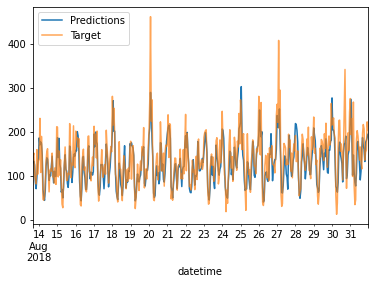

In [29]:
pd.DataFrame(model.predict(features_test), index = target_test.index).plot();
target_test.plot(alpha = 0.7)
plt.legend(['Predictions', 'Target']);

Мы видим, что метрика улучшилась до 35 (по сравнению с 40 без учета сезонности), и график предсказаний (синяя линия) лучше покрывает график правильных ответов (оранжевая линия). Значит, наша цель достигнута - мы смогли улучшить наш результат, модель прогнозирует с погрешностью 35 по сравнению с требуемой 48.